# Data Processing

Let's start by importing all of the modules we'll need. The main ones we need to import are:
- torch for general PyTorch functionality
- torch.nn and torch.nn.functional for neural network based functions
- torch.optim for our optimizer which will update the parameters of our neural network
- torch.utils.data for handling the dataset
- torchvision.transforms for data augmentation
- torchvision.datasets for loading the dataset
- sklearn's metrics for visualizing a confusion matrix
- sklearn's decomposition and manifold for visualizing the neural network's representations in two dimensions
- matplotlib for plotting

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

Set the random seeds for reproducability

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
root_dir = '../'

data_dir = os.path.join(root_dir, 'src/data/raw')
train_dir = os.path.join(data_dir, 'train')

models_dir = os.path.join(root_dir, 'models')

First, we load the `train_data` from the `train` folder. 

Next, we want to *normalize* our data. This means we want it to have a mean of zero and a standard deviation of one. 

Why do we want to do this? Normalizing our data allows our models to train faster and to also help them avoid local minima, i.e. train more reliably.

We normalize our data by subtracting the mean and dividing by the standard deviation of our dataset. First, we need to calculate the mean and standard deviation. **Note**: it is important that the mean and standard deviation are only calculated over the training set and not the test set. We do not want to use any information at all from the test set and should only look at it when we are calculating our test loss.

To calculate the means and standard deviations we get the actual data (the images) using the `.data.` attribute of our training data, convert them into floating point numbers and then use the built in `mean` and `std` functions to calculate the mean and standard deviation, respectively. The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255.

The mean and std must only be calculated from the training data. 
This will load PIL images by default so we pass the `ToTensor` transform which converts all the PIL images to tensors and scales them from 0-255 to 0-1.

We then loop through each image and calculate the mean and std across the height and width dimensions with `dim = (1,2)`, summing all the means and stds and then finding the average by dividing them by the number of examples, `len(train_data)`.


In [4]:
train_data = datasets.ImageFolder(train_dir, transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.6499, 0.4723, 0.5844])
Calculated stds: tensor([0.1422, 0.1467, 0.1282])


Now to actually load our data. As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://pytorch.org/docs/stable/torchvision/models.html) page.

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

Now we've calculated our mean and standard deviation how do we actually use them? We use Torchvision's `transforms`. 

A `transform` states how our data should be augmented and processed. Data augmentation involves manipulating the available training data in a way that artifically creates more training examples. We use `transforms.Compose` to built a list of transformations that will be applied to the image. 

The transforms we use are:
- `RandomRotation` - randomly rotates the image between `(-x, +x)` degrees, where we have set `x = 5`. Note the `fill=(0,)` is due to a [bug](https://github.com/pytorch/vision/issues/1759) in some versions of torchvision. 
- `RandomCrop` - this first adds `padding` around our image, 2 pixels here, to artifically make it bigger, before taking a random `28x28` square crop of the image.
- `ToTensor()` - this converts the image from a PIL image into a PyTorch tensor.
- `Normalize` - this subtracts the mean and divides by the standard deviations given. 

The first two transformations have to be applied before `ToTensor` as they should both be applied on a PIL image. `Normalize` should only be applied to the images after they have been converted into a tensor. See the Torchvision documentation for [transforms that should be applied to PIL images](https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image) and [transforms that should be applied on tensors](https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-torch-tensor).

We have two lists of transforms, a train and a test transform. The train transforms are to artificially create more examples for our model to train on. We do not augment our test data in the same way as we want a consistent set of examples to evaluate our final model on. The test data, however, should still be normalized.

In [5]:
train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

valid_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

We load our data with our transforms...

In [6]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

In [7]:
classes = train_data.classes

Then, we use the `random_split` function to take a random 10% of the training set to use as a validation set. The remaining 90% will stay as the training set.

In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

...and then overwrite the validation transforms, making sure to do a `deepcopy` to stop this also changing the training data transforms.

In [9]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = valid_transforms

We can simply check the `len` of the datasets to see how many examples are within each.

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 4500
Number of validation examples: 500


Next, we'll create the iterators with the largest batch size that fits on our GPU. 

In [11]:
BATCH_SIZE = 16

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right.

In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [13]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

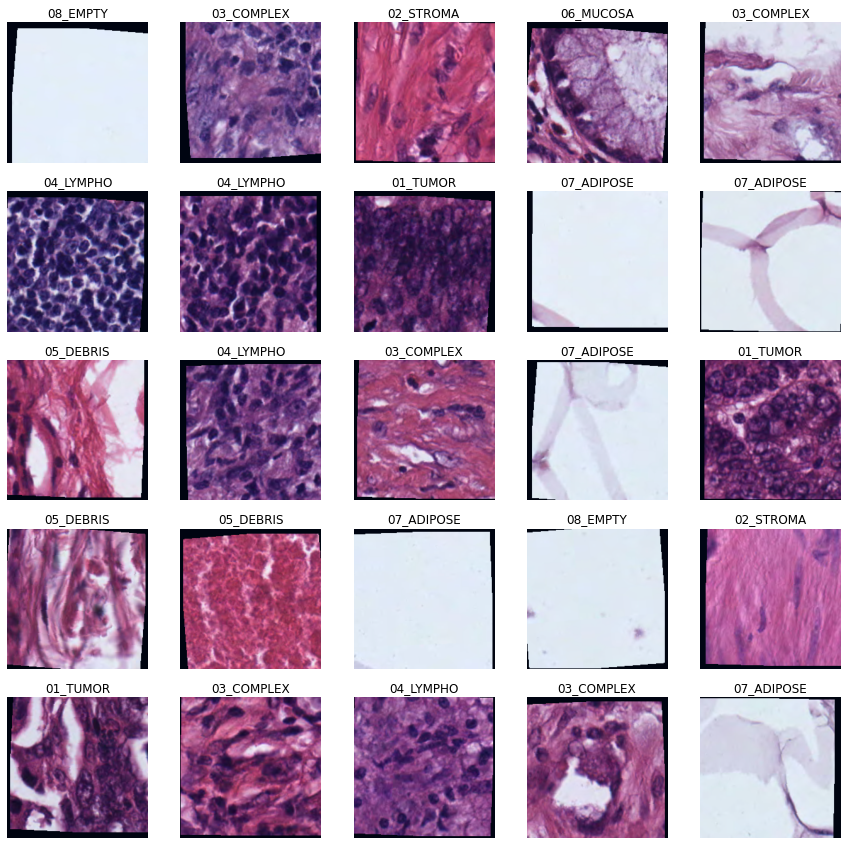

In [14]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

plot_images(images, labels, classes)

change the names of each class provided by the dataset's `.classes`. We'll make a `format_label` function which will strip off the number at the start of each class and convert them into title case.

In [15]:
def format_label(label):
    label = label.split('_')[-1]
    label = label.title()
    return label

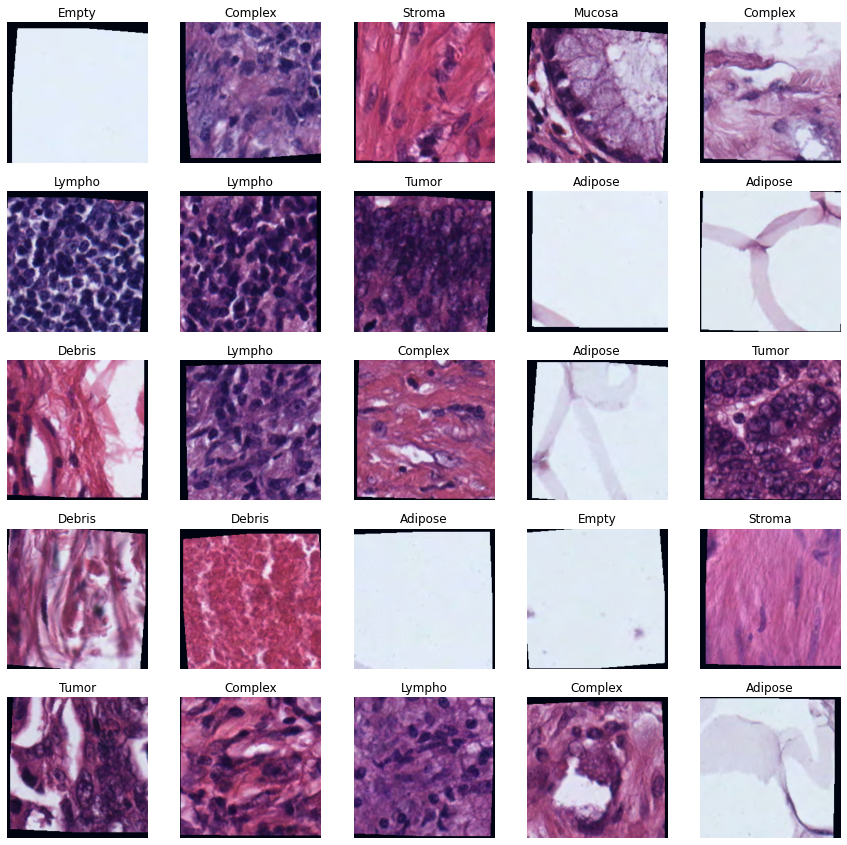

In [16]:
classes = [format_label(c) for c in classes]

plot_images(images, labels, classes)

# Model Building

we load the pre-trained ResNet model.

In [17]:
pretrained_model = models.resnet50(pretrained = True)

In [18]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We can see that the final linear layer for the classification, `fc`, has a 1000-dimensional output as it was pre-trained on the ImageNet dataset, which has 1000 classes.

Our dataset, however, only has 8 classes, so we first create a new linear layer with the required dimensions.

In [19]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

Then, we replace the pre-trained model's linear layer with our own, randomly initialized linear layer.


In [20]:
pretrained_model.fc = fc

In [32]:
model = pretrained_model
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,524,424 trainable parameters


# Training the Model

Next we'll move on to training our model. As in previous notebooks, we'll use the learning rate finder to set a suitable learning rate for our model.

We start by initializing an optimizer with a very low learning rate, defining a loss function (`criterion`) and device, and then placing the model and the loss function on to the device.

In [23]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We define the learning rate finder class for implementing once cycle learning


In [52]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

We then define our learning rate finder and run the range test.

In [38]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we define a function to plot the results of the range test.

In [39]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

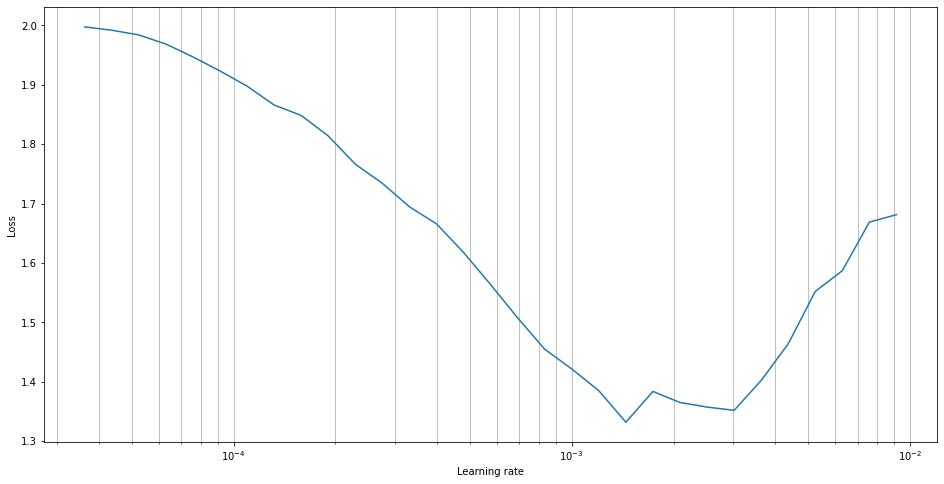

In [40]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

We can see that the loss reaches a minimum at around $0.5x10^{-3}$.

A good learning rate to choose here would be the middle of the steepest downward curve - which is around $2x10^{-4}$.

We can then set the learning rates of our model using discriminative fine-tuning - a technique used in transfer learning where later layers in a model have higher learning rates than earlier ones.

We use the learning rate found by the learning rate finder as the maximum learning rate - used in the final layer - whilst the remaining layers have a lower learning rate, gradually decreasing towards the input. 

In [41]:
FOUND_LR = 2e-4

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

Next up, we set the learning rate scheduler. A learning rate scheduler dynamically alters the learning rate whilst the model is training. We'll be using the one cycle learning rate scheduler, however [many](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) schedulers are available in PyTorch.

The one cycle learning rate scheduler starts with a small initial learning rate which is gradually increased to a maximum value - the value found by our learning rate finder - it then slowly decreases the learning rate to a final value smaller than the initial learning rate. This learning rate is updated after every parameter update step, i.e. after every training batch. For our model, the learning rate for the final `fc` layer throughout training will look like:

![](assets/lr-scheduler.png)

As we can see, it starts at slightly less than $1x10^{-4}$ before gradually increasing to the maximum value of $1x10^{-3}$ at around a third of the way through training, then it begins decreasing to almost zero.

The different parameter groups defined by the optimizer for the discriminative fine-tuning will all have their own learning rate curves, each with different starting and maximum values.

The hypothesis is that the initial stage where the learning rate increases is a "warm-up" phase is used to get the model into a generally good area of the loss landscape. The middle of the curve, where the learning rate is at maximum is supposedly good for acting as a regularization method and prevents the model from overfitting or becoming stuck in saddle points. Finally, the "cool-down" phase, where the learning rate decreases, is used to reach small crevices in the loss surface which have a lower loss value.

The one cycle learning rate also cycles the momentum of the optimizer. The momentum is cycled from a maximum value, down to a minimum and then back up to the maximum where it is held constant for the last few steps. The default maximum and minimum values of momentum used by PyTorch's one cycle learning rate scheduler should be sufficient and we will not change them.

To set-up the one cycle learning rate scheduler we need the total number of steps that will occur during training. We simply get this by multiplying the number of epochs with the number of batches in the training iterator, i.e. number of parameter updates. We get the maximum learning rate for each parameter group and pass this to `max_lr`. **Note:** if you only pass a single learning rate and not a list of learning rates then the scheduler will assume this learning rate should be used for all parameters and will **not** do discriminative fine-tuning.

In [42]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [43]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Next up is the training function. 

This will:
- put our model into `train` mode
- iterate over our dataloader, returning batches of (image, label)
- place the batch on to our GPU, if we have one
- clear the gradients calculated from the last batch
- pass our batch of images, `x`, through to model to get predictions, `y_pred`
- calculate the loss between our predictions and the actual labels
- calculate the accuracy between our predictions and the actual labels
- calculate the gradients of each parameter
- update the parameters by taking an optimizer step
- update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode.

The scheduler is updated by calling `scheduler.step()`. This should always be called **after** `optimizer.step()` or else the first learning rate of the scheduler will be skipped. 

Not all schedulers need to be called after each training batch, some are only called after each epoch. In that case, the scheduler does not need to be passed to the `train` function and can be called in the main training loop.

In [57]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

As the one cycle scheduler should only be called after each parameter update, it is not called here as we do not update parameters whilst evaluating.

The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients it will be faster and use less memory. 

In [56]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

Next, a small helper function which tells us how long an epoch has taken.

In [47]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we can train our model!

In [58]:
EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(models_dir,'final-model.pt'))

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 4m 14s
	Train Loss: 1.132 | Train Acc: 68.06%
	 Val. Loss: 0.323 |  Val. Acc: 87.70%
Epoch: 02 | Epoch Time: 4m 21s
	Train Loss: 0.355 | Train Acc: 88.08%
	 Val. Loss: 0.226 |  Val. Acc: 92.77%
Epoch: 03 | Epoch Time: 4m 37s
	Train Loss: 0.269 | Train Acc: 90.98%
	 Val. Loss: 0.263 |  Val. Acc: 92.19%
Epoch: 04 | Epoch Time: 4m 43s
	Train Loss: 0.212 | Train Acc: 93.22%
	 Val. Loss: 0.183 |  Val. Acc: 95.31%
Epoch: 05 | Epoch Time: 4m 45s
	Train Loss: 0.169 | Train Acc: 94.39%
	 Val. Loss: 0.175 |  Val. Acc: 93.36%
